
# Apex Financial: Fraud Detection with Logistic Regression 🛡️💳

This Colab-ready notebook walks through a **complete Logistic Regression workflow** using a fictional but realistic fraud story from **Apex Financial**, a mid-sized bank.

We step into the shoes of **Sarah, Lead Fraud Analyst**, who must make **millisecond-level decisions** on Cyber Monday:

> **“For each incoming transaction, should we BLOCK it as fraud (1) or APPROVE it as legitimate (0)?”**

We’ll follow this structure:

1. **Installation**
2. **Dataset Preparation** (create a synthetic fraud dataset from the story)
3. **Descriptive Analysis & Exploration**
4. **Train–Test Split**
5. **Model Building (Logistic Regression)**
6. **Model Evaluation**
7. **Business Interpretation & Threshold Tuning (like Sarah’s 0.70 rule)**



## 1. Installation

In Colab, most libraries are already installed.  
We still include an installation cell so this notebook is **self-contained** if run elsewhere.


In [1]:

# If you're running this outside Google Colab and missing packages, uncomment and run:
# !pip install -q numpy pandas matplotlib scikit-learn



## 2. Imports & Setup

We’ll import the core libraries needed for:

- Data manipulation (**pandas**, **numpy**)
- Visualization (**matplotlib**)
- Machine learning (**scikit-learn**)


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_fscore_support
)

%matplotlib inline

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



## 3. Dataset Preparation 💾

### 3.1. Features Inspired by Sarah’s Story

In the Cyber Monday siege at **Apex Financial**, Sarah’s model looks at **dozens of features**.  
We’ll focus on four core ones mentioned in the story:

1. **X₁ – Velocity (seconds_since_last_tx)**  
   - How many seconds since the last transaction on this card?  
   - Very **short gaps** (e.g. multiple transactions within a few seconds) are suspicious: typical of **bot testing** stolen cards.

2. **X₂ – Amount (amount_usd)**  
   - Is the amount typical for this user?  
   - We’ll simulate realistic purchase amounts (small purchases + occasional big-ticket items).

3. **X₃ – Device (is_new_device)**  
   - `1` if this transaction comes from a **new/unseen device** for this card, else `0`.  
   - Fraudsters often use **new devices**.

4. **X₄ – Location Mismatch (location_mismatch)**  
   - `1` if the **shipping zip code ≠ billing zip code**, else `0`.  
   - Mismatched addresses can be a strong fraud signal.

### 3.2. Generating a Synthetic Fraud Dataset

We will simulate:

- **n_transactions ≈ 50,000** Cyber Monday transactions
- A small percentage labeled as **fraud = 1**
- Fraud probability driven by:
  - Very **short velocity**
  - **Higher amounts**
  - **New device**
  - **Location mismatch**

We’ll generate a **latent risk score**, convert it to a probability using a **sigmoid**, then sample the fraud label from that probability (this is consistent with the Logistic Regression assumption).


In [3]:

n_transactions = 50_000

# 1) Transaction amount (USD), skewed: many small transactions, few large
amount_usd = np.random.exponential(scale=80, size=n_transactions)  # base small amounts
# Add a chance for high-ticket items (e.g., TVs, laptops)
high_value_indices = np.random.rand(n_transactions) < 0.02  # ~2% high-value
amount_usd[high_value_indices] += np.random.uniform(500, 5000, size=high_value_indices.sum())
amount_usd = np.clip(amount_usd, 1, 6000)

# 2) Velocity: seconds since last transaction on this card
# Many transactions are spaced out; some are very rapid (bots)
seconds_since_last_tx = np.random.exponential(scale=1800, size=n_transactions)  # avg 30 mins
seconds_since_last_tx = np.clip(seconds_since_last_tx, 0, 24*3600)

# 3) New device flag
is_new_device = (np.random.rand(n_transactions) < 0.12).astype(int)  # ~12% on new devices

# 4) Location mismatch flag
location_mismatch = (np.random.rand(n_transactions) < 0.08).astype(int)  # ~8% mismatch

# Build a latent "fraud risk score" using a linear combination of features
# Higher risk if:
# - Very short time since last tx (bots rapidly testing cards)
# - High amount
# - New device
# - Location mismatch
base_intercept = -4.0  # overall low fraud rate
velocity_term = 0.004 * np.maximum(0, 200 - seconds_since_last_tx)  # strong effect under 200s
amount_term = 0.0006 * np.maximum(0, amount_usd - 50)  # extra risk for amounts > $50
new_device_term = 1.5 * is_new_device
location_term = 2.0 * location_mismatch

fraud_risk_score = (
    base_intercept
    + velocity_term
    + amount_term
    + new_device_term
    + location_term
)

# Sigmoid to convert risk score -> probability of fraud
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fraud_probability = sigmoid(fraud_risk_score)

# Sample binary labels (0 = legitimate, 1 = fraud)
fraud_label = np.random.binomial(1, fraud_probability)

# Create DataFrame
data = pd.DataFrame({
    "amount_usd": np.round(amount_usd, 2),
    "seconds_since_last_tx": np.round(seconds_since_last_tx, 0),
    "is_new_device": is_new_device,
    "location_mismatch": location_mismatch,
    "is_fraud": fraud_label
})

data.head()


,amount_usd,seconds_since_last_tx,is_new_device,location_mismatch,is_fraud
0,37.54,149.0,0,0,0
1,240.81,2096.0,0,0,0
2,105.34,209.0,0,0,0
3,73.04,4063.0,0,0,0
4,13.57,1749.0,0,0,0



### 3.3. Quick Data Sanity Check


In [4]:

data.describe()


,amount_usd,seconds_since_last_tx,is_new_device,location_mismatch,is_fraud
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,134.445461,1809.458620,0.11882,0.081600,0.041080
std,433.343923,1804.910014,0.32358,0.273757,0.198477
min,1.000000,0.000000,0.00000,0.000000,0.000000
25%,23.390000,517.000000,0.00000,0.000000,0.000000
50%,56.815000,1257.000000,0.00000,0.000000,0.000000
75%,115.145000,2512.000000,0.00000,0.000000,0.000000
max,5498.030000,20616.000000,1.00000,1.000000,1.000000



### 3.4. Fraud Rate (Class Balance)

Let’s see what percentage of transactions are labeled **fraudulent**.


In [5]:

fraud_counts = data["is_fraud"].value_counts().sort_index()
fraud_rates = data["is_fraud"].value_counts(normalize=True).sort_index()

print("Class counts (0 = legitimate, 1 = fraud):")
print(fraud_counts)
print("\nClass percentages:")
print((fraud_rates * 100).round(2).astype(str) + " %")


Class counts (0 = legitimate, 1 = fraud):
is_fraud
0    47946
1     2054
Name: count, dtype: int64

Class percentages:
is_fraud
0    95.89 %
1     4.11 %
Name: proportion, dtype: object



## 4. Descriptive Analysis & Exploration 🔍

Before fitting Logistic Regression, Sarah needs to understand:

- How do **fraudulent vs legitimate** transactions differ by each feature?
- Is fraud more likely with:
  - **Short velocity?**
  - **Higher amounts?**
  - **New devices?**
  - **Location mismatches?**



### 4.1. Feature Distributions by Fraud Label


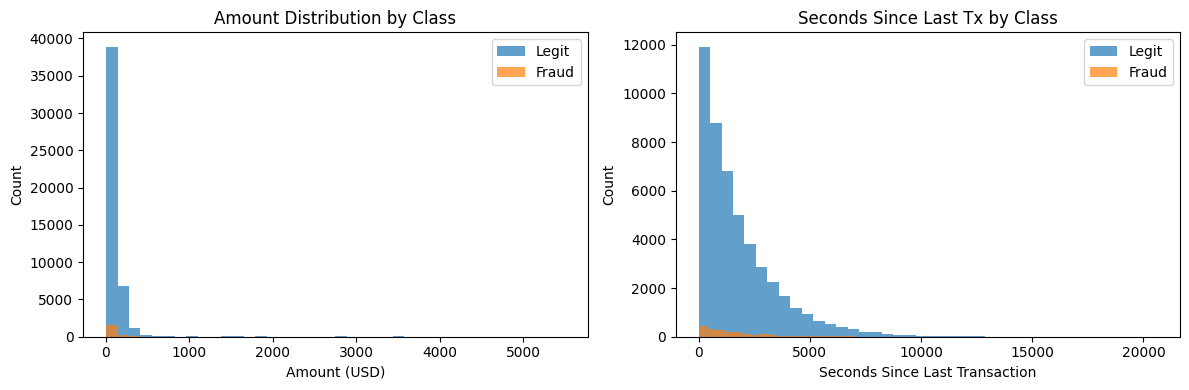

In [6]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Amount distribution
axes[0].hist(data.loc[data["is_fraud"] == 0, "amount_usd"], bins=40, alpha=0.7, label="Legit")
axes[0].hist(data.loc[data["is_fraud"] == 1, "amount_usd"], bins=40, alpha=0.7, label="Fraud")
axes[0].set_title("Amount Distribution by Class")
axes[0].set_xlabel("Amount (USD)")
axes[0].set_ylabel("Count")
axes[0].legend()

# Velocity distribution
axes[1].hist(data.loc[data["is_fraud"] == 0, "seconds_since_last_tx"], bins=40, alpha=0.7, label="Legit")
axes[1].hist(data.loc[data["is_fraud"] == 1, "seconds_since_last_tx"], bins=40, alpha=0.7, label="Fraud")
axes[1].set_title("Seconds Since Last Tx by Class")
axes[1].set_xlabel("Seconds Since Last Transaction")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.show()



### 4.2. Categorical Features vs Fraud Rate


In [7]:

cat_summary = (
    data.groupby(["is_new_device", "location_mismatch"])["is_fraud"]
    .mean()
    .reset_index()
    .rename(columns={"is_fraud": "fraud_rate"})
)

cat_summary["fraud_rate_percent"] = (cat_summary["fraud_rate"] * 100).round(2)
cat_summary


,is_new_device,location_mismatch,fraud_rate,fraud_rate_percent
0,0,0,0.021237,2.12
1,0,1,0.139297,13.93
2,1,0,0.091557,9.16
3,1,1,0.407249,40.72



## 5. Train–Test Split 🧪

We’ll predict **`is_fraud`** using:

- `amount_usd`
- `seconds_since_last_tx`
- `is_new_device`
- `location_mismatch`

We split into:
- **Training set** – to fit the Logistic Regression model
- **Test set** – to evaluate performance on unseen transactions


In [8]:

feature_cols = ["amount_usd", "seconds_since_last_tx", "is_new_device", "location_mismatch"]
X = data[feature_cols]
y = data["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

X_train.shape, X_test.shape


((37500, 4), (12500, 4))


## 6. Model Building: Logistic Regression 🧮

### 6.1. Why Logistic (Not Linear) Regression?

- **Linear Regression** outputs arbitrary numbers (e.g. -20, 500).  
  Those are hard to interpret as **fraud probabilities**.
- **Logistic Regression** passes the linear combination of inputs through a **sigmoid function**, squashing it to a value between **0 and 1**.

\[
p(\text{fraud} = 1 \mid X) = \sigma(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)
\]

Where \(\sigma(z) = \dfrac{1}{1 + e^{-z}}\) is the **S-curve** Sarah relies on.

The output is directly interpretable as:

> **“Probability that this transaction is fraud.”**


In [9]:

# Create and fit Logistic Regression model
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced"  # handle class imbalance more robustly
)
log_reg.fit(X_train, y_train)

# Model parameters
intercept = log_reg.intercept_[0]
coefs = log_reg.coef_[0]

print(f"Intercept (β0): {intercept:.4f}\n")
print("Coefficients (βi) for each feature:")
for col, c in zip(feature_cols, coefs):
    print(f"  {col:22s}: {c:.6f}")


Intercept (β0): -0.7984

Coefficients (βi) for each feature:
  amount_usd            : 0.000639
  seconds_since_last_tx : -0.000036
  is_new_device         : 1.631467
  location_mismatch     : 2.067811



### 6.2. From Coefficients to Business Meaning

We can exponentiate the coefficients to get **odds ratios**:

- If coefficient βᵢ > 0 → increasing that feature **increases odds of fraud**
- If coefficient βᵢ < 0 → increasing that feature **decreases odds of fraud**


In [10]:

odds_ratios = np.exp(coefs)
coef_summary = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coefs,
    "odds_ratio": odds_ratios
})
coef_summary


,feature,coefficient,odds_ratio
0,amount_usd,0.000639,1.000639
1,seconds_since_last_tx,-0.000036,0.999964
2,is_new_device,1.631467,5.111369
3,location_mismatch,2.067811,7.907498



## 7. Model Evaluation 📏

The Logistic Regression model outputs a **probability of fraud** for each transaction.

We’ll first evaluate it using the **standard 0.50 threshold**:

- If `P(fraud) >= 0.5` → predict **fraud (1)**
- Else → predict **legitimate (0)**


In [11]:

# Predicted probabilities for the positive class (fraud = 1)
y_proba_test = log_reg.predict_proba(X_test)[:, 1]

# Using default threshold 0.5
threshold_default = 0.5
y_pred_default = (y_proba_test >= threshold_default).astype(int)

cm_default = confusion_matrix(y_test, y_pred_default)
tn, fp, fn, tp = cm_default.ravel()

print("Confusion Matrix (Threshold = 0.50):")
print(cm_default)

print("\nClassification Report (Threshold = 0.50):")
print(classification_report(y_test, y_pred_default, digits=3))

print("TP (True Fraud Caught):      ", tp)
print("FP (Legit Blocked):          ", fp)
print("FN (Fraud Missed):           ", fn)
print("TN (Legit Approved Correct): ", tn)


Confusion Matrix (Threshold = 0.50):
[[9706 2281]
 [ 207  306]]

Classification Report (Threshold = 0.50):
              precision    recall  f1-score   support

           0      0.979     0.810     0.886     11987
           1      0.118     0.596     0.197       513

    accuracy                          0.801     12500
   macro avg      0.549     0.703     0.542     12500
weighted avg      0.944     0.801     0.858     12500

TP (True Fraud Caught):       306
FP (Legit Blocked):           2281
FN (Fraud Missed):            207
TN (Legit Approved Correct):  9706



### 7.1. ROC Curve & AUC

The **ROC curve** shows the tradeoff between:

- **True Positive Rate** (Recall on fraud)  
- **False Positive Rate** (Blocking real customers)

The **AUC (Area Under Curve)** summarizes performance into a single number.


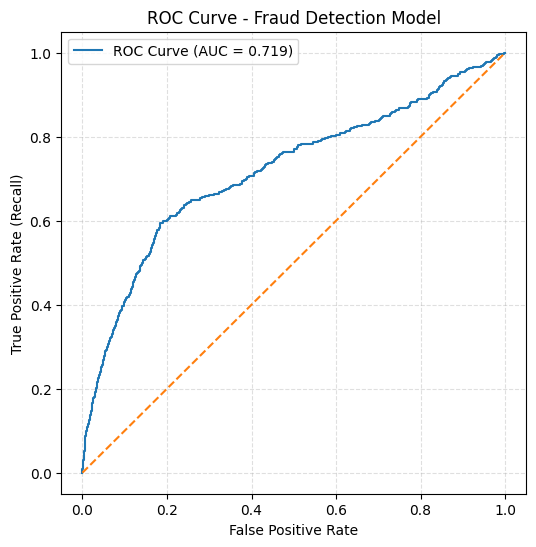

In [12]:

fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
auc_score = roc_auc_score(y_test, y_proba_test)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Fraud Detection Model")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()



## 8. Threshold Tuning Like Sarah 🎛️

In the story, Sarah **does not** blindly use 0.50.

> Given the severity of the attack, she decides:  
> **“Set the threshold to 0.70. Anything over 70% probability of being a bot gets auto-blocked.”**

We’ll compare performance at:

- **Threshold = 0.50** (standard)
- **Threshold = 0.70** (Sarah’s Cyber Monday rule)


In [13]:

def evaluate_at_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return {
        "threshold": threshold,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

results_default = evaluate_at_threshold(y_test, y_proba_test, 0.50)
results_sarah   = evaluate_at_threshold(y_test, y_proba_test, 0.70)

pd.DataFrame([results_default, results_sarah])


,threshold,tn,fp,fn,tp,precision,recall,f1
0,0.5,9706,2281,207,306,0.118284,0.596491,0.197419
1,0.7,10605,1382,289,224,0.139477,0.436647,0.211420



**Interpretation:**

- As we **raise the threshold** from 0.50 → 0.70:
  - The model becomes **more conservative** about calling something fraud.
  - We usually get **fewer False Positives** (fewer legit customers blocked).
  - But we may **miss more fraud** (more False Negatives).

On a day like Cyber Monday under attack, Sarah may **accept more False Positives** in exchange for **catching more fraud**, or vice versa depending on business risk policy.

This is a **business decision**, not a purely technical one.



## 9. The $4,000 TV Transaction 🎬📺

Recall the story’s climax:

> A \$4,000 OLED TV hits the queue.  
> - IP in Ohio, billing in Ohio (looks legit).  
> - But **3 minutes earlier**, the card was used for a \$1 soda in Florida.  
> - Velocity + location mismatch are **major red flags**.

We’ll simulate such a transaction and run it through the trained model.


In [14]:

# Approximate "TV transaction" feature values from the story
tv_transaction = pd.DataFrame({
    "amount_usd": [4000.0],            # Large amount
    "seconds_since_last_tx": [180.0],  # 3 minutes since last tx (in story it's cross-state)
    "is_new_device": [1],              # Assume new device
    "location_mismatch": [1]           # Ohio vs Florida usage
})

tv_proba = log_reg.predict_proba(tv_transaction)[:, 1][0]

print("Features for the $4,000 TV transaction:")
display(tv_transaction)

print(f"\nPredicted probability of fraud: {tv_proba:.3f}")
print(f"Decision at threshold 0.70: {'BLOCK' if tv_proba >= 0.70 else 'APPROVE'}")


Features for the $4,000 TV transaction:


,amount_usd,seconds_since_last_tx,is_new_device,location_mismatch
0,4000.0,180.0,1,1



Predicted probability of fraud: 0.996
Decision at threshold 0.70: BLOCK



Even if the IP and billing address look “normal”, the **combination** of:

- Recent usage in a far-away location (Florida vs Ohio)
- Short time gap between transactions (3 minutes)
- New device
- High amount (\$4,000)

pushes the **fraud probability high**, and the model can confidently recommend **BLOCK**.

This is exactly the kind of complex pattern **rules-based systems** often miss, but **Logistic Regression** (and other ML models) can capture.



## 10. Takeaways 🧠

- Sarah’s problem is a classic **binary classification** task: **Fraud (1) vs Legitimate (0)**.
- **Logistic Regression** converts a linear combination of features into a **probability** between 0 and 1.
- This probability is **interpretable** and allows flexible **threshold tuning**:
  - 0.50 for balanced usage
  - 0.70 (or higher) for high-risk situations like Cyber Monday attacks
- Metrics such as **precision**, **recall**, **F1**, and **ROC-AUC** help quantify tradeoffs:
  - **Recall (fraud)**: “Of all actual frauds, how many did we catch?”
  - **Precision (fraud)**: “Of all blocked transactions, how many were truly fraud?”

In production, Sarah would:

1. Continually **retrain** the model with new data.
2. Use more features: user history, IP reputation, merchant risk, device fingerprinting, etc.
3. Combine Logistic Regression with more advanced models and **human review queues** for borderline cases.

But even this simple model already shows how **Logistic Regression** turns chaotic Cyber Monday traffic into **probability-driven, defensible decisions**.
